In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential
from keras import backend as K 

Using TensorFlow backend.


In [31]:
# Fast Text pretrained
WIKI_KO_DATA = './data/cc.ko.300.bin.gz'

# Fast Text Embedding 모델
FT_EMBEDDING_PATH = f'./model/ft_embedding'

# 학습 데이터
DATA_PATH = './data/10000_data.tsv'

# 최종 모델
MODEL_PATH = './model/10000_doc_model.json'
MODEL_WEIGHT_PATH = './model/10000_doc_model_weight.h5'

In [3]:
if not os.path.exists('./model'):
    os.makedirs('./model')

### Gensim FastText
- cc.ko.300.bin.gz : [Fast Text에서 제공하는 위키백과 한국어 데이터](https://fasttext.cc/docs/en/crawl-vectors.html)

In [4]:
if os.path.isfile(FT_EMBEDDING_PATH):
    # 학습된 파일이 있는 경우
    print('trained model exist.')
    from gensim.models import FastText
    ko_model = FastText.load(FT_EMBEDDING_PATH)
    print('model loaded')
    
else:
    # 학습된 파일이 없는 경우
    print('start to train')
    from gensim import models
    if os.path.isfile(WIKI_KO_DATA):
        ko_model = models.fasttext.load_facebook_model(WIKI_KO_DATA)
        ko_model.save(FT_EMBEDDING_PATH)
        print('model saved')
    else:
        print('no wiki_ko_data. please download cc.ko.300.bin.gz from [https://fasttext.cc/docs/en/crawl-vectors.html]')

trained model exist.
model loaded


In [5]:
for w, sim in ko_model.wv.similar_by_word('파이썬', 10):
    print(f'{w}: {sim}')

Python: 0.565061628818512
자이썬: 0.5624369382858276
레일스: 0.5598082542419434
파이썬을: 0.5595801472663879
언어용: 0.5288202166557312
파이썬의: 0.5250024795532227
프로그래밍: 0.5225088000297546
wxPython: 0.5222088098526001
파이썬이나: 0.5201171636581421
함수형: 0.5187377333641052


In [6]:
print(f'vocab size : {len(ko_model.wv.vocab)}')

vocab size : 2000000


### Train Model

In [44]:
data = pd.read_csv(DATA_PATH, sep='\t', usecols=['label', 'sentence'])
data.sample(5)

,label,sentence
3515,1,새로운 언어 v를 소개합니다 v v라는 프로그래밍 언어가 새로 개발되었다고 들어서 ...
1989,1,vue spring boot jpa spring pododev pododevcom ...
3972,1,windows windows 관리자 권한에서 네트워크 드라이브가 안 보일 때 윈도우...
7329,1,python python sysgetrefcount reference count s...
8467,1,자바스크립트 개발자라면 알아야 할 33가지 개념 17 자바스크립트 클래스 vs 프로...


In [45]:
data.sentence

0       todo 리스트를 1달간 사용해본 후기 왜 todo 리스트를 사용했나요 위 질문에 ...
1       양평 블룸비스타 콩순이 패밀리룸이 궁금하신분에게 드리는 후기 늦은 여름 휴가로 양평...
2       javascript js 자바스크립트 문자열 메소드 javascript 문자열 메소...
3       우리 시장에는 어떤 교육이 필요할까요 1 시장적합형 교육과 기술적합형 교육 며칠전 ...
4       저 많은 국민은행 앱들은 대체 다 어디다 쓰는 걸까 대략 정리 구글플래이 스토어에서...
                              ...                        
9995    nginx rest kubernetes 164 kubernetes nginx ing...
9996    git https javascript html web ui modal design ...
9997    spring boot spring spring boot오류 처리에 대해 서론오류 처...
9998    http3 http3 httpoverquic quic은 quick udp inter...
9999    spring kotlin kotlin spring boot security thym...
Name: sentence, Length: 10000, dtype: object

In [46]:
def sentenceToVector(sentence):
    words = sentence.split(' ')
    words_num = len(words)
    vector = np.zeros(300) # ko_model shape가 300
    for word in words:
        vector += ko_model[word]
    return vector/words_num
data['vector'] = data.sentence.apply(sentenceToVector)

/Users/nero/.virtualenvs/dc/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [47]:
def numberToOneHot(num):
    oneHot = [0]*2
    oneHot[num] = 1
    return oneHot

data['oneHot'] = data.label.apply(numberToOneHot)

In [48]:
data.head(3)

,label,sentence,vector,oneHot
0,1,todo 리스트를 1달간 사용해본 후기 왜 todo 리스트를 사용했나요 위 질문에 ...,"[0.013710441264420491, 0.0032995063650540692, ...","[0, 1]"
1,0,양평 블룸비스타 콩순이 패밀리룸이 궁금하신분에게 드리는 후기 늦은 여름 휴가로 양평...,"[0.00013062362416590355, -0.032540909874690126...","[1, 0]"
2,1,javascript js 자바스크립트 문자열 메소드 javascript 문자열 메소...,"[-0.04456514536979653, 0.00961365589007203, 0....","[0, 1]"


In [49]:
data.vector[0].shape

(300,)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(data.vector, data.label, test_size=0.33, random_state=321)

In [51]:
def reshape(series, embedding_dim):
    result = np.array(series.tolist())
    result = result.reshape(result.shape[0], embedding_dim, 1)
    return result

In [52]:
X_train = reshape(X_train, 300)
X_test = reshape(X_test, 300)
print(f'X_train shape = {X_train.shape} / X_test shape = {X_test.shape}')

X_train shape = (6700, 300, 1) / X_test shape = (3300, 300, 1)


In [53]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [24]:
K.clear_session()

model = Sequential()
# model.add(Embedding(len(ko_model.wv.vocab), 300)) # 임베딩 벡터의 차원은 300 <- fast text쓰므로 안씀
model.add(Dense(300, input_shape=(X_train.shape[1], 1), activation="relu"))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
history = model.fit(X_train, np.asarray(y_train), epochs=10, batch_size=100, validation_split=0.3)

Train on 4690 samples, validate on 2010 samples
Epoch 1/10
4690/4690 [==============================] - 12s 2ms/sample - loss: 0.5997 - acc: 0.6932 - f1_m: 0.7857 - precision_m: 0.7027 - recall_m: 0.9206 - val_loss: 0.5674 - val_acc: 0.7264 - val_f1_m: 0.8332 - val_precision_m: 0.7167 - val_recall_m: 1.0000
Epoch 2/10
4690/4690 [==============================] - 11s 2ms/sample - loss: 0.5402 - acc: 0.7362 - f1_m: 0.8458 - precision_m: 0.7377 - recall_m: 0.9939 - val_loss: 0.5184 - val_acc: 0.7303 - val_f1_m: 0.8344 - val_precision_m: 0.7211 - val_recall_m: 0.9954
Epoch 3/10
4690/4690 [==============================] - 10s 2ms/sample - loss: 0.4978 - acc: 0.7593 - f1_m: 0.8537 - precision_m: 0.7664 - recall_m: 0.9669 - val_loss: 0.4870 - val_acc: 0.7657 - val_f1_m: 0.8485 - val_precision_m: 0.7570 - val_recall_m: 0.9712
Epoch 4/10
4690/4690 [==============================] - 12s 3ms/sample - loss: 0.4561 - acc: 0.7896 - f1_m: 0.8661 - precision_m: 0.8063 - recall_m: 0.9386 - val_loss: 0

In [25]:
# evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, np.asarray(y_test), verbose=0)

In [26]:
print(f'f1_score : {f1_score} / precision : {precision} / recall : {recall}')

f1_score : 0.8873331546783447 / precision : 0.8541010618209839 / recall : 0.9279797077178955


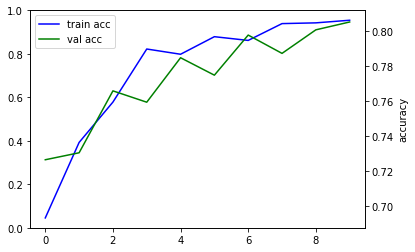

In [28]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

### Save Model

In [32]:
# save model
model_json = model.to_json()
with open(MODEL_PATH, "w") as json_file : 
    json_file.write(model_json)

In [33]:
# save weight
model.save_weights(MODEL_WEIGHT_PATH)

### Load Model

In [36]:
from tensorflow.keras.models import model_from_json
# load model
json_file = open(MODEL_PATH, "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [37]:
# load weight
loaded_model.load_weights(MODEL_WEIGHT_PATH)

In [54]:
# loaded_model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=['accuracy'])
loaded_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
# model evaluation
score = loaded_model.evaluate(X_train, np.asarray(y_train), verbose=0)

print("%s : %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

acc : 81.30%


### Load Embedding Model

In [66]:
from gensim.models import FastText
embedding = FastText.load(FT_EMBEDDING_PATH)

### Predict

In [106]:
from bs4 import BeautifulSoup
import re

# Preprocess
def preprocess(x):
    # html tag 삭제
    x = BeautifulSoup(x, "html.parser").get_text()
    
    # 소문자로 변경
    x = x.lower()
    
    # 영어, 숫자, 한글, 띄어쓰기만 남기기
    x = re.sub('[^가-힣\sa-zA-Z0-9]', '', x)
    
    # 띄어쓰기 1개로 줄이기
    x = re.sub('\s{2,}', ' ', x)
    
    # 앞뒤 공백 제거
    x = x.strip()
    
    return x

In [107]:
# Embedding
def sentenceToVector(embedding, sentence):
    words = sentence.split(' ')
    words_num = len(words)
    vector = np.zeros(300) # ko_model shape가 300
    for word in words:
        vector += embedding[word]
    return vector/words_num

In [115]:
# Reshape
def reshape(embedding, arr):
    result = np.array(arr)
    result = result.reshape(1, embedding.wv.vector_size, 1)
    return result

In [144]:
sample = "[ 제주 표선 맛집 ] 메밀밭에 가시리 - 아이와 가기 좋은 식당 >> 클릭으로 블로그 구독하기 << 안녕하세요, 동글엄마예요^^표선에 있는 말선 명품 제주 농원에서 귤따기 체험을 하고2019/11/14 - [ 제주 아이와 가볼만 한 곳 ] 말선 명품 제주 농원 - 감귤 따기 체험노창래 농부님 추천받아 농원 근처에서 저녁식사를 하게 되었어요.동글이가 잠들지 않았다면..가보지 못했을 곳인데 푸욱 잠들었던 동글이덕에 저녁식"
sample = preprocess(sample)
sample = sentenceToVector(embedding, sample)
sample = reshape(embedding, sample)
sample.shape

/Users/nero/.virtualenvs/dc/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


(1, 300, 1)

In [145]:
confidence = loaded_model.predict(sample)[0][0]

In [146]:
import math
if confidence > 0.5:
    print(f'{math.ceil(confidence * 100)}% 확신으로 IT 글입니다.')
else:
    print(f'{math.ceil(confidence * 100)}% 확신으로 IT 글이 아닙니다.')

10% 확신으로 IT 글이 아닙니다.
